In [2]:
#⚠️Generación del csv⚠️
# No ejecutar, ya que puede tardar mucho, El .csv ya esta creado este codigo es para ver como ha sido creado
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

dataset_folder = "dataset"
data = []
labels = []

for pose_folder in os.listdir(dataset_folder):
    pose_path = os.path.join(dataset_folder, pose_folder)
    if os.path.isdir(pose_path):
        for img_name in os.listdir(pose_path):
            if img_name.endswith(('.jpg', '.png')):
                img_path = os.path.join(pose_path, img_name)
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = pose.process(image_rgb)

                if results.pose_landmarks:
                    landmarks = []
                    for lm in results.pose_landmarks.landmark:
                        landmarks.extend([lm.x, lm.y, lm.z])

                    data.append(landmarks)
                    labels.append(pose_folder)

df = pd.DataFrame(data)
df['label'] = labels
df.to_csv("landmarks_dataset.csv", index=False)

print("Landmarks guardados en landmarks_dataset.csv")

pose.close()


Landmarks guardados en landmarks_dataset.csv


C:\Users\USUARIO\miniconda3\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0301 - loss: 4.5562 - val_accuracy: 0.0423 - val_loss: 4.4734 - learning_rate: 5.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1167 - loss: 3.7164 - val_accuracy: 0.1376 - val_loss: 3.9829 - learning_rate: 5.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2055 - loss: 3.0798 - val_accuracy: 0.2239 - val_loss: 3.4436 - learning_rate: 5.0000e-04
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2843 - loss: 2.6531 - val_accuracy: 0.3687 - val_loss: 2.7140 - learning_rate: 5.0000e-04
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3587 - loss: 2.3721 - val_accuracy: 0.4218 - val_loss: 2.2388 - learning_rate: 5.0000e-04
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4113 - loss: 2.0722 - val_accuracy: 0.4739 - val_loss: 2.0486 - learning_rate: 5.0000e-04
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

Epoch 44/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7792 - loss: 0.6428 - val_accuracy: 0.7032 - val_loss: 1.1988 - learning_rate: 2.5000e-04
Epoch 45/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7910 - loss: 0.6099 - val_accuracy: 0.7176 - val_loss: 1.2437 - learning_rate: 2.5000e-04
Epoch 46/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7944 - loss: 0.6056 - val_accuracy: 0.7059 - val_loss: 1.2170 - learning_rate: 2.5000e-04
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6990 - loss: 1.1927


Precisión en test: 0.68


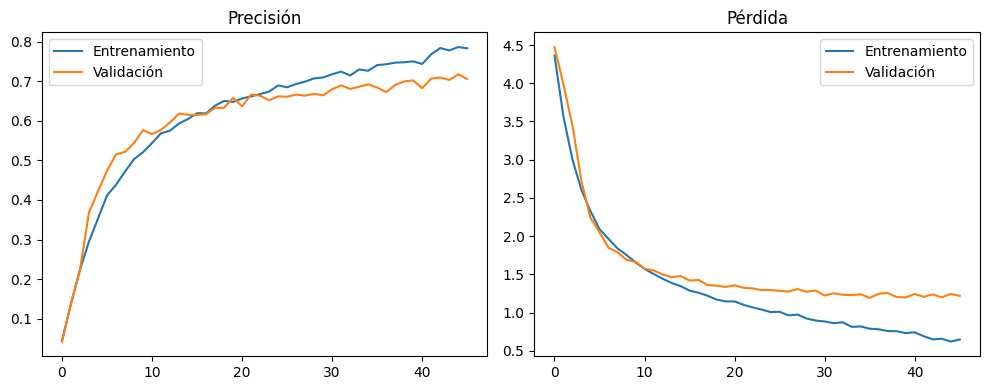

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

csv_file = "landmarks_dataset.csv"
df = pd.read_csv(csv_file, header=None)

# Separar características (X) y etiquetas (y)
X = df.iloc[:, :-1].values  
y = df.iloc[:, -1].values   

# Convertir etiquetas a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Arquitectura de la red
model = Sequential([
    BatchNormalization(input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compilar modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks para mejorar entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, reduce_lr])

# Evaluación el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {test_acc:.2f}")

# Guardar modelo y scaler
model.save("modelo_pose_mejorado.h5")
joblib.dump(scaler, 'scaler.pkl')

# Visualizar entrenamiento
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import joblib

model = tf.keras.models.load_model("modelo_pose_mejorado.h5")
scaler = joblib.load('scaler.pkl')

# Carpeta con los nombres de las poses (etiquetas)
dataset_folder = "dataset"
pose_names = os.listdir(dataset_folder)

# Inicializar MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Ruta de la imagen
img_path = "fotos/fotoej2.jfif"
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Procesar la imagen con MediaPipe
results = pose.process(image_rgb)

if results.pose_landmarks:
    # Extraer los landmarks
    landmarks = []
    for lm in results.pose_landmarks.landmark:
        landmarks.extend([lm.x, lm.y, lm.z])

    # Normalizar los landmarks (escalar la entrada)
    landmarks_scaled = scaler.transform([landmarks])  # Normaliza como una fila (1, 99)
    
    # Predecir con el modelo
    predictions = model.predict(landmarks_scaled)
    
    # Obtener la clase predicha
    predicted_class = np.argmax(predictions, axis=1)

    # Obtener el nombre de la pose predicha
    predicted_pose = pose_names[predicted_class[0]]
    print(f"Predicción de la pose: {predicted_pose}")
else:
    print("No se detectaron landmarks en la imagen.")

pose.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicción de la pose: ananda balasana
